In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

import tensorflow as tf

# Read Train data

In [207]:

train_home_team_statistics_df = pd.read_csv('./train/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./train/Y_train_supp.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [208]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train_data_copy = train_data.copy(deep=True)

imp = IterativeImputer()

train_data = imp.fit_transform(train_data)
train_data = pd.DataFrame(train_data, index=train_data_copy.index, columns=train_data_copy.columns)
train_scores = train_scores.loc[train_data.index]

c:\Users\matej\Desktop\challengedata\Football Can you guess the winner\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [211]:
train_data.describe()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
count,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,...,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000
mean,4.377385,4.229298,4.511339,4.150892,4.482001,4.273496,4.075770,4.622543,4.505244,5.060401,...,3.906351,2.805219,3.590151,3.936032,3.701260,3.269836,3.790909,3.758026,3.845942,3.687389
std,2.850305,2.837250,2.806821,2.861173,2.720034,2.780895,2.757533,2.795662,2.802579,2.787344,...,2.823054,3.765127,2.722465,2.823259,3.694437,3.323727,2.675177,2.814694,2.444590,2.855905
min,0.000000,-0.171044,0.000000,0.000000,0.000000,-0.655202,0.000000,0.000000,0.000000,-1.125491,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.178627,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.878128,2.000000,2.000000,3.000000,2.000000,3.000000,...,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,4.000000,0.000000,3.000000,4.000000,5.000000,3.000000,3.463830,3.000000,3.698708,3.000000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,7.000000,...,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,5.000000,6.000000,5.000000,6.000000
max,10.000000,10.065523,10.000000,10.000000,10.000000,11.622970,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [213]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=42)


In [214]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_valid = ss.transform(X_valid)

In [222]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model configuration
input_dim = X_train.shape[1]
reg_lambda = 0.005  # Regularization factor for L2 regularization

# Building the model
model = Sequential([
    Dense(128, activation="sigmoid", kernel_regularizer=l2(reg_lambda)),
    Dropout(0.1),
    Dense(64, activation="sigmoid", kernel_regularizer=l2(reg_lambda)),
    Dropout(0.1),
    Dense(32, activation="sigmoid", kernel_regularizer=l2(reg_lambda)),
    Dropout(0.1),
    Dense(1, activation="linear")
])

# Compiling the model
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mean_absolute_error"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Training the model
history = model.fit(X_train, y_train, epochs=200, batch_size=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.9056 - mean_absolute_error: 1.4450 - val_loss: 3.7290 - val_mean_absolute_error: 1.2621 - learning_rate: 0.0010
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6852 - mean_absolute_error: 1.2867 - val_loss: 3.2683 - val_mean_absolute_error: 1.2348 - learning_rate: 0.0010
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3144 - mean_absolute_error: 1.2570 - val_loss: 3.0507 - val_mean_absolute_error: 1.2234 - learning_rate: 0.0010
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1056 - mean_absolute_error: 1.2481 - val_loss: 2.9273 - val_mean_absolute_error: 1.2172 - learning_rate: 0.0010
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0809 - mean_absolute_error: 1.2673 - val_loss: 2.8843 - val_mean_absolute_error: 1.2220 - learning_rate: 0.0010
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9621 - mean_absolute_error: 1.2507 - val_loss: 2.8278 - val_mean_absolute

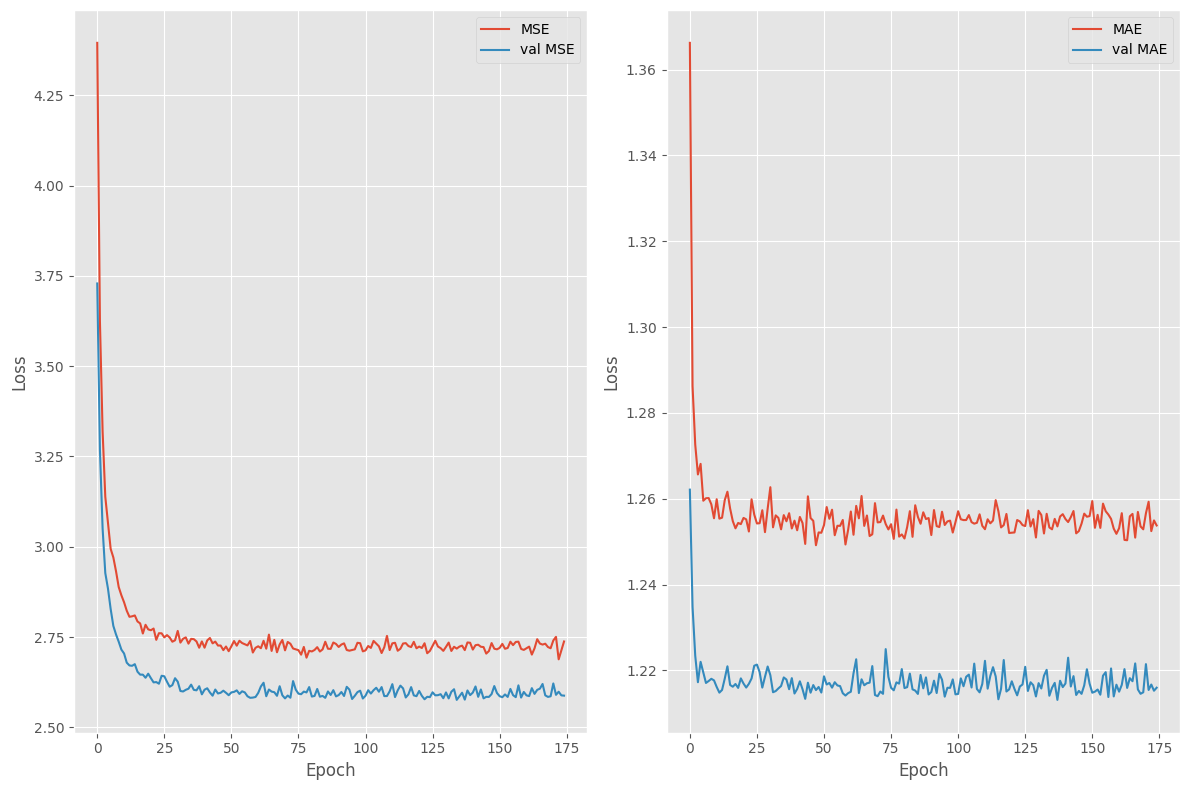

In [223]:
num_epochs = len(history.history["loss"])

fig, ax = plt.subplots(ncols=2, figsize=(12, 8))

ax[0].plot(np.arange(num_epochs), history.history["loss"], label="MSE")
ax[0].plot(np.arange(num_epochs), history.history["val_loss"], label="val MSE")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(num_epochs), history.history["mean_absolute_error"], label="MAE")
ax[1].plot(np.arange(num_epochs), history.history["val_mean_absolute_error"], label="val MAE")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()

In [259]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Define the parameters for the XGBoost model
params = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,      # the training step for each iteration
    'objective': 'reg:squarederror',  # regression with squared loss
    'eval_metric': 'rmse',  # root mean square error as the evaluation metric
    "n_estimators": 100,
}

# Specify the number of iterations (trees)
num_round = 100

# Train the model
model = XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30)

# Prediction (just an example, assuming you want to see how it performs on the validation set)
print(f"Train MSE: {mean_squared_error(y_train, model.predict(X_train))}")
print(f"Test MSE: {mean_squared_error(y_test, model.predict(X_test))}")

[0]	validation_0-rmse:1.67666
[1]	validation_0-rmse:1.64455
[2]	validation_0-rmse:1.63045
[3]	validation_0-rmse:1.62445
[4]	validation_0-rmse:1.61993
[5]	validation_0-rmse:1.61976
[6]	validation_0-rmse:1.62498
[7]	validation_0-rmse:1.62804


c:\Users\matej\Desktop\challengedata\Football Can you guess the winner\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:1.63195
[9]	validation_0-rmse:1.63523
[10]	validation_0-rmse:1.63732
[11]	validation_0-rmse:1.63887
[12]	validation_0-rmse:1.64134
[13]	validation_0-rmse:1.64071
[14]	validation_0-rmse:1.64311
[15]	validation_0-rmse:1.64755
[16]	validation_0-rmse:1.64895
[17]	validation_0-rmse:1.64936
[18]	validation_0-rmse:1.65184
[19]	validation_0-rmse:1.65475
[20]	validation_0-rmse:1.65671
[21]	validation_0-rmse:1.65855
[22]	validation_0-rmse:1.66083
[23]	validation_0-rmse:1.66400
[24]	validation_0-rmse:1.66562
[25]	validation_0-rmse:1.66826
[26]	validation_0-rmse:1.66848
[27]	validation_0-rmse:1.67078
[28]	validation_0-rmse:1.67267
[29]	validation_0-rmse:1.67391
[30]	validation_0-rmse:1.67391
[31]	validation_0-rmse:1.67458
[32]	validation_0-rmse:1.67451
[33]	validation_0-rmse:1.67660
[34]	validation_0-rmse:1.67768
[35]	validation_0-rmse:1.67618
Train MSE: 2.0498115032284674
Test MSE: 2.7910178815835556


In [254]:
y_train_pred = model.predict(X_train).reshape(-1, 1)
y_test_pred = model.predict(X_test).reshape(-1, 1)

c:\Users\matej\Desktop\challengedata\Football Can you guess the winner\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


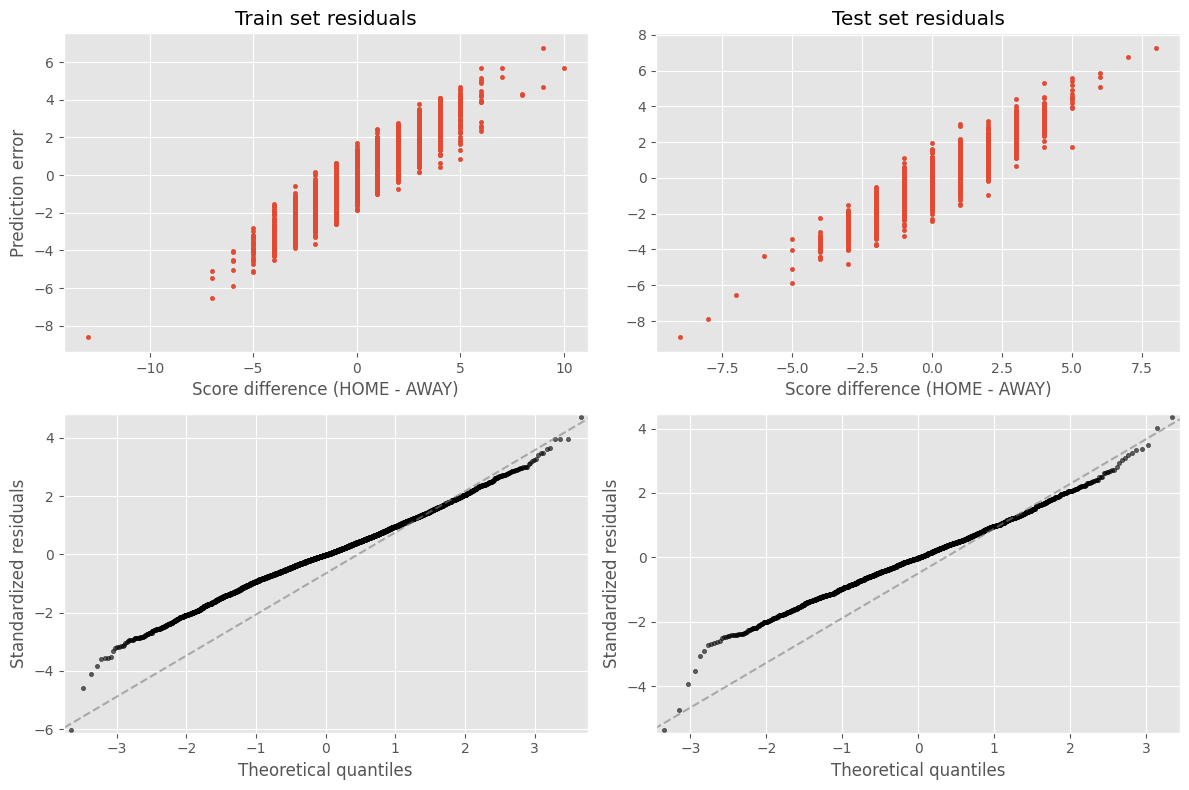

In [255]:
from scipy.stats import rankdata, normaltest, norm

def diagnostic_plot(y_train, y_train_pred, y_test, y_test_pred):
    resids_train = y_train - y_train_pred
    resids_train_ranks = rankdata(resids_train, method="min") / (len(resids_train) + 1)
    train_theo_quants = norm().ppf(resids_train_ranks)
    resids_mean = np.mean(resids_train)
    resids_std = np.std(resids_train, ddof=1)
    train_standard_resids = (resids_train - resids_mean) / resids_std
    
    resids_test = y_test - y_test_pred
    resids_test_ranks = rankdata(resids_test, method="min") / (len(resids_test) + 1)
    test_theo_quants = norm().ppf(resids_test_ranks)
    resids_mean = np.mean(resids_test)
    resids_std = np.std(resids_test, ddof=1)
    test_standard_resids = (resids_test - resids_mean) / resids_std
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    ax = ax.flatten()

    ax[0].scatter(y_train, resids_train, marker=".")
    ax[0].set_title("Train set residuals")
    ax[0].set_ylabel("Prediction error")
    ax[0].set_xlabel("Score difference (HOME - AWAY)")

    ax[1].scatter(y_test, resids_test, marker = ".")
    ax[1].set_title("Test set residuals")
    ax[1].set_xlabel("Score difference (HOME - AWAY)")
    
    
    min_theo = np.min(train_theo_quants); max_theo = np.max(train_theo_quants)
    min_resid = np.min(train_standard_resids); max_resid = np.max(train_standard_resids)
    ax[2].scatter(train_theo_quants, train_standard_resids, marker=".", color="black", alpha=0.6)
    ax[2].plot([min_theo - 0.5, max_theo + 0.5], [min_resid - 0.5, max_resid + 0.5],
               color="gray", alpha=0.6, linestyle="dashed")
    ax[2].set_xlim(min_theo - 0.1, max_theo + 0.1)
    ax[2].set_ylim(min_resid - 0.1, max_resid + 0.1)
    ax[2].set_xlabel("Theoretical quantiles")
    ax[2].set_ylabel("Standardized residuals")
    
    
    min_theo = np.min(test_theo_quants); max_theo = np.max(test_theo_quants)
    min_resid = np.min(test_standard_resids); max_resid = np.max(test_standard_resids)
    ax[3].scatter(test_theo_quants, test_standard_resids, marker=".", color="black", alpha=0.6)
    ax[3].plot([min_theo - 0.5, max_theo + 0.5], [min_resid - 0.5, max_resid + 0.5],
               color="gray", alpha=0.6, linestyle="dashed")
    ax[3].set_xlim(min_theo - 0.1, max_theo + 0.1)
    ax[3].set_ylim(min_resid - 0.1, max_resid + 0.1)
    ax[3].set_xlabel("Theoretical quantiles")
    ax[3].set_ylabel("Standardized residuals")

    plt.tight_layout()
    plt.show()
    

diagnostic_plot(y_train, y_train_pred, y_test, y_test_pred)

In [256]:
test_labels = pd.read_csv("./train/Y_train_1rknArQ.csv").set_index("ID")
test_labels = test_labels.loc[y_test.index]
test_labels

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
8961,1,0,0
724,0,0,1
9165,0,0,1
12165,0,0,1
8771,1,0,0
...,...,...,...
8288,0,1,0
3378,0,1,0
4007,0,0,1


In [257]:
y_test_pred_labels = pd.DataFrame({"HOME_WINS": np.zeros(test_labels.shape[0]),
                                   "DRAW": np.zeros(test_labels.shape[0]),
                                   "AWAY_WINS": np.zeros(test_labels.shape[0])},
                                  index=test_labels.index)

for i in range(len(y_test_pred)):
    if y_test_pred[i][0] > 0.5:
        y_test_pred_labels.iloc[i, 0] = 1.0
    elif y_test_pred[i][0] < -0.5:
        y_test_pred_labels.iloc[i, 2] = 1.0
    else:
        y_test_pred_labels.iloc[i, 1] = 1.0

In [258]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, multilabel_confusion_matrix

print(accuracy_score(test_labels, y_test_pred_labels))

0.386834620073141
